In [ ]:
#@title Shell function
from IPython.display import JSON
from google.colab import output
from subprocess import getoutput
import os

def shell(command):
  return JSON([getoutput(command)])
output.register_callback('shell', shell)

In [ ]:
#@title Take Photo
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='input.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  # display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

Saved to input.jpg


In [ ]:
#@title Record Video
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import uuid

def record_video(filename='video.webm', duration=10):
    js = Javascript('''
    async function recordVideo(duration) {
      const div = document.createElement('div');
      const record = document.createElement('button');
      record.textContent = 'Start Recording';
      const stop = document.createElement('button');
      stop.textContent = 'Stop Recording';
      stop.style.display = 'none';
      div.appendChild(record);
      div.appendChild(stop);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true, audio: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      const recorder = new MediaRecorder(stream);
      let data = [];

      recorder.ondataavailable = event => data.push(event.data);
      recorder.onstop = async () => {
        const blob = new Blob(data, {type: 'video/webm'});
        const url = await new Promise(resolve => {
          const reader = new FileReader();
          reader.onloadend = () => resolve(reader.result.split(',')[1]);
          reader.readAsDataURL(blob);
        });
        google.colab.kernel.invokeFunction('notebook.uploadVideo', [url], {});
      };

      record.onclick = () => {
        recorder.start();
        record.style.display = 'none';
        stop.style.display = 'inline';
        setTimeout(() => stop.click(), duration * 1000);
      };

      stop.onclick = () => {
        recorder.stop();
        stream.getTracks().forEach(track => track.stop());
        div.remove();
      };
    }
    ''')

    display(js)
    video_id = uuid.uuid4().hex  # Generate a unique ID for the file

    # Start recording for the specified duration
    print("Recording video for max", duration, "seconds...")

    # Call JavaScript to record video
    eval_js(f'recordVideo({duration})')

def upload_video(data):
    # Decode the video data
    binary = b64decode(data)
    webm_file_path = f"/content/input.webm"

    # Save the video as a WebM file first
    with open(webm_file_path, 'wb') as f:
        f.write(binary)

    # Now, convert the WebM video to MP4 using ffmpeg
    mp4_file_path = webm_file_path.replace('.webm', '.mp4')
    if os.path.exists(mp4_file_path):
      os.remove(mp4_file_path)

    # Use ffmpeg to convert WebM to MP4
    os.system(f"ffmpeg -i {webm_file_path} -vcodec libx264 -acodec aac {mp4_file_path}")

    # Remove the WebM file after conversion
    os.remove(webm_file_path)

    print(f"Video saved as MP4: {mp4_file_path}")
    return mp4_file_path

# Register the upload_video function to be called in JavaScript when the video is recorded
from google.colab import output
output.register_callback('notebook.uploadVideo', upload_video)

# Run the video recording process
try:
    record_video(duration=10)  # Set duration in seconds
except Exception as err:
    print("Error:", str(err))

<IPython.core.display.Javascript object>

Recording video for max 10 seconds...
Video saved as MP4: /content/input.mp4


In [ ]:
#@title Colab Shell
%%html
<div id=term_demo></div>
<script src="https://code.jquery.com/jquery-latest.js"></script>
<script src="https://cdn.jsdelivr.net/npm/jquery.terminal/js/jquery.terminal.min.js"></script>
<link href="https://cdn.jsdelivr.net/npm/jquery.terminal/css/jquery.terminal.min.css" rel="stylesheet"/>
<script>
  $('#term_demo').terminal(async function(command) {
      if (command !== '') {
          try {
              let res = await google.colab.kernel.invokeFunction('shell', [command])
              let out = res.data['application/json'][0]
              this.echo(new String(out))
          } catch(e) {
              this.error(new String(e));
          }
      } else {
          this.echo('');
      }
  }, {
      greetings: 'Welcome to Colab Shell',
      name: 'colab_demo',
      height: 250,
      prompt: 'colab > '
  });

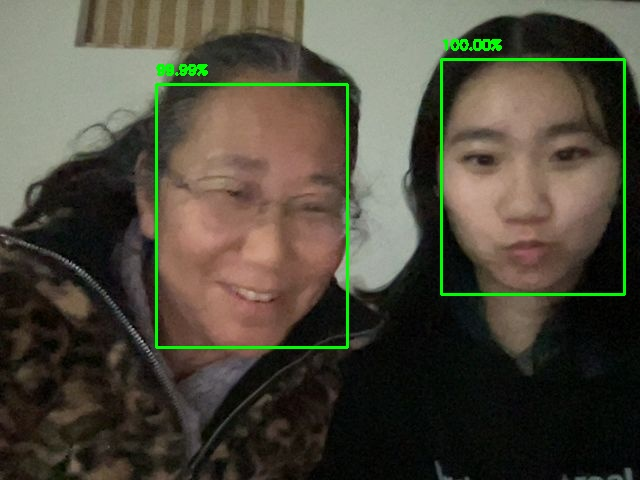

In [ ]:
#@title Display Output Image
from IPython.display import Image

# Display the image
Image('output.jpg')

In [ ]:
#@title Display Output Video
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "output.mp4"

# Compressed video path
compressed_path = "output_compressed.mp4"

if os.path.exists(compressed_path):
  os.remove(compressed_path)

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# Instructions



download contents of DL1 in google drive & upload files into the runtime files of this colab notebook

## **for images:**<br>
1. take a photo using Take Photo section
2. this photo will be saved to input.jpg
3. you can also upload your own photo to the colab runtime files


output will be saved to output.jpg
<br>

**python detect_faces.py --image *IMAGENAME*.jpg --prototxt deploy.prototxt.txt --model res10_300x300_ssd_iter_140000.caffemodel**
<br>



## **for videos:**<br>
1. record a video using Record Video section
2. this video will be saved to input.mp4
3. you can also upload your own video to the colab runtime files


output will be saved to output.mp4
<br>

**python detect_faces_video.py --video *VIDEONAME*.mp4 --prototxt deploy.prototxt.txt --model res10_300x300_ssd_iter_140000.caffemodel**
<br>
